In [1]:
#Basic setups 
import numpy as np
from skimage import io
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
from dataloader import load_data
from PCA import PCA


In [3]:
from random import shuffle
import math
def dataSplit(K,data):
    """This function is used to implement k-fold cross-validation"""
    #Shuffle the dataset to get more accurate performance
    
    #print("original shape:",data.shape)
    
    index = np.arange(0,len(data))
    shuffle(index)
    shuffled_data= data[index]
    
    
    #print("shuffled shape:",shuffled_data.shape)
    
    #Initialize list for train,test and val 
    train = []
    val = []
    test = []
    
    #Split the data into training, testing and handout set
    size = len(data)
    set_size = math.floor(size/K)

    for i in range(K):
        # select subsets of data
        test_i = shuffled_data[i*set_size:(i+1)*set_size] #ith cut as training set for ith fold
        
        #print("shape of test_i",test_i.shape)
        
        temp = (i+1)%K
        val_i = shuffled_data[temp*set_size:(temp+1)*set_size] # (i+1)%kth cut as val set for ith fold
        
        #print("shape of val_i",val_i.shape)
        
        if i < temp:
            temp1 = shuffled_data[:i*set_size]
            temp2 = shuffled_data[(temp+1)*set_size:]
            train_i = np.concatenate((temp1, temp2),axis=0)
            
        if i > temp:
            temp1 = shuffled_data[0:temp*set_size]
            temp2 = shuffled_data[(temp+1)*set_size:i*set_size]
            temp3 = shuffled_data[(i+1)*set_size:]
            train_i_temp = np.concatenate((temp1, temp2),axis=0)
            train_i = np.concatenate((train_i_temp, temp3),axis=0)
            
        #print("shape of train_i",train_i.shape)
        
        train.append(train_i)
        val.append(val_i)
        test.append(test_i)
    return train, val, test

In [4]:
def img_flatten(img):
    """This function is used to convert 2-D images to 1-D vectors"""
    flatten_img = []
    for i in range(len(img)):
        flatten_img.append(img[i].flatten())
    return np.array(flatten_img)

def projectPC(x,mean_image, eigen_values, eigen_vectors):
    """This function is used to project the data x on the given training set x_train"""
    msd = x - mean_image
    projected_image = np.matmul(msd,eigen_vectors)/eigen_values
    projected = np.insert(projected_image,0,1,axis=1)
    return projected

In [5]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))



def accuracy(x,y,weight):
    x = np.asmatrix(x)
    y = np.asmatrix(y)
    weight = np.asmatrix(weight)
    
    y_hat = sigmoid(x * weight.T)
    #print("shape of y_hat",y_hat.shape)
    
    prediction =  [0 if m < 0.5 else 1 for m in y_hat] 
    
    correct = np.zeros(y.shape[0])
    for i in range(y.shape[0]):
        if y[i]-prediction[i]==0:
            correct[i]=1
    accuracy = sum(correct)/len(correct) 
    return accuracy
    
def cross_entropy(x,y,weight):
    x = np.asmatrix(x)
    y = np.asmatrix(y)
    weight = np.asmatrix(weight)
    
    #print(weight.shape)
    
    y_hat = sigmoid(x*weight.T)
    
    #print("shape of y,y_hat",y.shape,y_hat.shape)
    
    cost = np.multiply(-y,np.log(y_hat))-np.multiply((1-y),np.log(1-y_hat))
    
    error = np.sum(cost)/len(x)
    return error

def gradientDescent(x,y,weight,learning_rate):
    x = np.asmatrix(x)
    y = np.asmatrix(y)
    weight = np.asmatrix(weight)
    
    #print("checkgradD,weightshape:",weight.shape)
    
    y_hat = sigmoid(x*weight.T)
    error = y_hat-y
    
    gradient = x.T * error / len(x)
    gradient= np.squeeze(np.asarray(gradient))
    
    #print("checkgradD,gradientshape:",weight.shape)
    
    weight_updated = weight - learning_rate*gradient
    weight_updated = np.asarray(weight_updated)
    
    #print("checkgradD,weightshapeupdate:",weight_updated.shape)
    
    return gradient,weight_updated

In [6]:
#Load data 
data,cnt = load_data("./aligned/")


minivan= data.get('Minivan')
convertible = data.get('Convertible')

minivan_flatten = img_flatten(minivan)
convertible_flatten = img_flatten(convertible)

print("shape of minivan:",minivan_flatten.shape)
print("shape of convertible:",convertible_flatten.shape)



Car types: ['Convertible', 'Minivan', 'Pickup', 'Sedan'] 

Convertible: 149 # of images
Minivan: 148 # of images
Pickup: 150 # of images
Sedan: 150 # of images
shape of minivan: (148, 60000)
shape of convertible: (149, 60000)


In [146]:
num_fold = 10
max_iter = 800
learning_rate = 5
num_PC = 100

trainM, valM, testM = dataSplit(num_fold,minivan_flatten)
trainC, valC, testC = dataSplit(num_fold,convertible_flatten)

In [147]:


#Initialize accuracy and error matrix
train_error = np.zeros((max_iter,num_fold))
val_error = np.zeros((max_iter,num_fold))
test_error = np.zeros((max_iter,num_fold))
            
train_acc = np.zeros((max_iter,num_fold))
val_acc = np.zeros((max_iter,num_fold))
test_acc = np.zeros((max_iter,num_fold))

average_train = np.zeros((1,max_iter))
average_val = np.zeros((1,max_iter))

test_accuracy = np.zeros((1,num_fold))

print("shape of matrix:",train_acc.shape)

    

shape of matrix: (800, 10)


In [148]:
def plot_top_PCs(eigenvectors,n):
    """This function is used plot top PCs"""
    imgs = []
    plt.figure()
    for i in range(n):
        eigen = eigenvectors[:,i]
        image = np.reshape(eigen,(200,300))
        imgs.append(image)
        plt.subplot(2,n/2,i+1)
        plt.imshow(imgs[i])

0th iteration :
1th iteration :
2th iteration :
3th iteration :
4th iteration :
5th iteration :
6th iteration :
7th iteration :
8th iteration :
9th iteration :


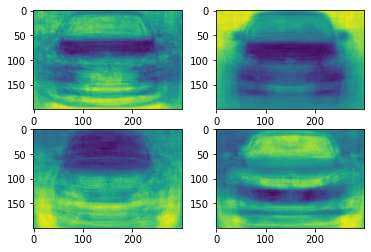

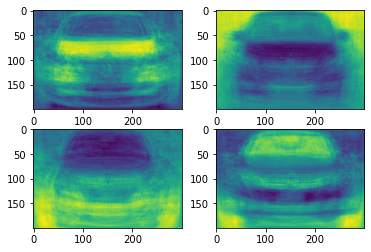

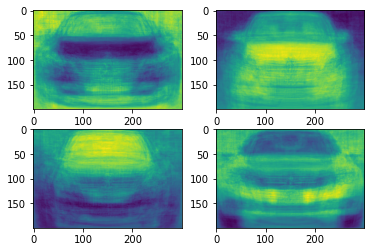

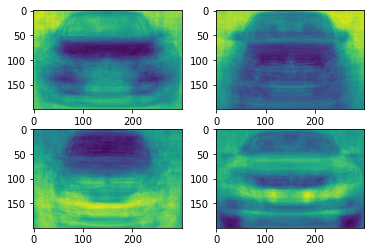

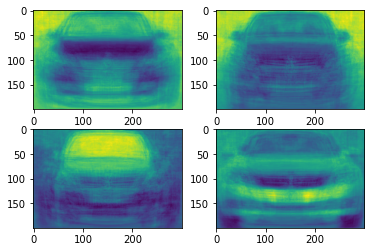

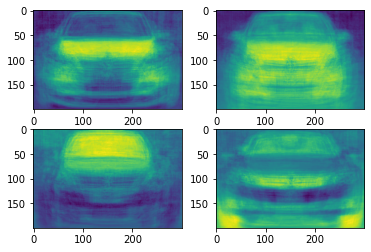

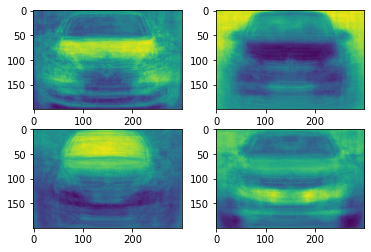

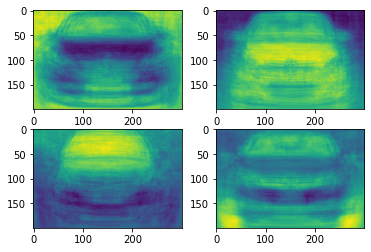

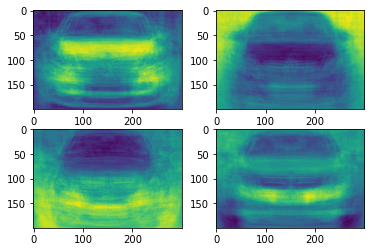

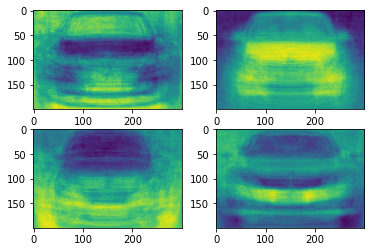

In [149]:
for fold in range(num_fold):
    print("%dth iteration :" %(fold))
    
    #generate train,test and val set
    train = np.concatenate((trainM[fold], trainC[fold]),axis=0)
    test = np.concatenate((testM[fold], testC[fold]),axis=0)
    val = np.concatenate((valM[fold], valC[fold]),axis=0)

    #print("shape of train set:",train.shape)
    #print("shape of test set:",test.shape)
    #print("shape of val set:",val.shape)
    
    y_train = np.concatenate((np.ones(len(trainM[fold])), np.zeros(len(trainC[fold]))), axis=0)
    y_train= np.array([[i] for i in y_train])

    y_test = np.concatenate((np.ones(len(testM[fold])), np.zeros(len(testC[fold]))), axis=0)
    y_test = np.array([[i] for i in y_test])

    y_val = np.concatenate((np.ones(len(valM[fold])), np.zeros(len(valC[fold]))), axis=0)
    y_val = np.array([[i] for i in y_val])
    
    #Perform PCA to find top PCs on training set
    projected, mean_image, top_sqrt_eigen_values, top_eigen_vectors = PCA(train, num_PC)
    x_train = np.insert(projected, 0, 1, axis=1)

    #Project test and val set on top PCs
    x_test = projectPC(test,mean_image, top_sqrt_eigen_values, top_eigen_vectors)
    x_val = projectPC(val,mean_image, top_sqrt_eigen_values, top_eigen_vectors)
    
    weight = np.zeros(len(x_train[0]))
    for j in range(max_iter):
        grad,weight = gradientDescent(x_train,y_train,weight,learning_rate)
    
        #print("shape of weight",weight.shape)
    
        train_error[j][fold] = cross_entropy(x_train,y_train,weight)
        train_acc[j][fold] = accuracy(x_train,y_train,weight)
                                                 
        #Calculate the error for hold out set using updated weight
        val_error[j][fold] = cross_entropy(x_val,y_val,weight)
        val_acc[j][fold] = accuracy(x_val,y_val,weight)
                                                 
                
        #Calculate the error for test set using updated weight
        test_error[j][fold] = cross_entropy(x_test,y_test,weight)
        test_acc[j][fold] = accuracy(x_test,y_test,weight)
        
    val_temp = val_error[:,fold]
    
    #print("shape of val_temp:",val_temp.shape)
    
    index_min = np.argmin(val_temp)
    test_accuracy[0][fold] = test_acc[index_min][fold]
    

    plot_top_PCs(top_eigen_vectors,4)
    plt.savefig('./plots/5c_top4eign'+str(fold)+'th.png')

In [144]:
print(test_error)

[[ 0.64109054  0.63088123  0.67202364 ...  0.66015126  0.645618
   0.62179193]
 [ 2.2498266   2.18516667  2.29616355 ...  2.28735492  2.25727875
   2.21807566]
 [22.10429698 22.12056344 22.21202119 ... 22.15908973 22.11826287
  22.02522404]
 ...
 [ 0.22558057  0.61691183  1.3569624  ...  0.88713621  0.67848891
          nan]
 [ 0.22556666  0.6169311   1.35695524 ...  0.88723925  0.67853368
          nan]
 [ 0.22555277  0.61695029  1.35694809 ...  0.88734222  0.67857847
          nan]]


<Figure size 432x288 with 0 Axes>

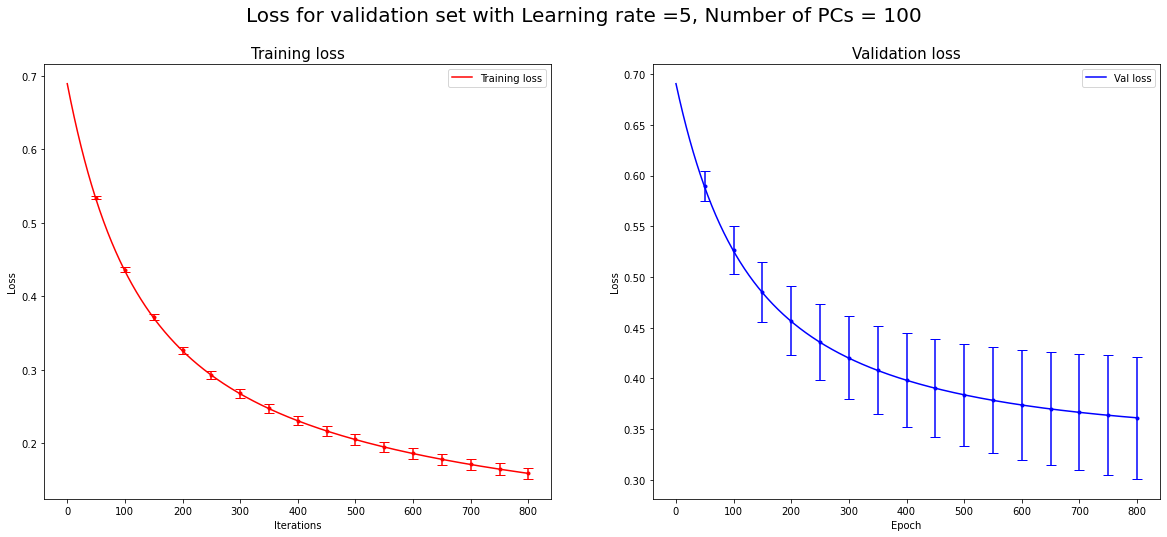

In [150]:
#Plot average loss curves for training and val sets
std_train = np.zeros((1,max_iter))
std_val = np.zeros((1,max_iter))

for q in range(max_iter):
    average_train[0][q] = np.mean(train_error[q][:])
    average_val[0][q] = np.mean(val_error[q][:])
    std_train[0][q] = np.std(train_error[q][:])
    std_val[0][q] = np.std(val_error[q][:])

fig=plt.figure()
fig = plt.figure(figsize=(20, 8))


plt.subplot(1,2,1)
#plt.title("Loss for training set with Learning rate ="+str(learning_rate)+", Number of PCs = "+str(num_PC))
plt.plot(average_train[0,:],color = 'red',label = 'Training loss')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend()

errorbar_x = np.zeros((1,int(max_iter/50) ))
errorbar_train = np.zeros((1,int(max_iter/50)))
errorbar_val = np.zeros((1,int(max_iter/50) ))
errorbar_y_train = np.zeros((1,int(max_iter/50)))
errorbar_y_val = np.zeros((1,int(max_iter/50)))

for p in range(int(max_iter/50)):
    
    errorbar_x[0][p] = 50*(p+1)
    errorbar_train[0][p] = std_train[0][50*(p+1)-1]
    errorbar_val[0][p] = std_val[0][50*(p+1)-1]
    errorbar_y_train[0][p] = average_train[0][50*(p+1)-1]
    errorbar_y_val[0][p] = average_val[0][50*(p+1)-1]
    



plt.errorbar(errorbar_x[0,:], errorbar_y_train[0,:], errorbar_train[0,:],fmt = '.r', capsize=5)
plt.title('Training loss',fontsize=15)
plt.subplot(1,2,2)
plt.title('Validation loss',fontsize=15)
plt.plot(average_val[0,:],color = 'blue',label = 'Val loss')
#plt.title("Loss for validation set with Learning rate ="+str(learning_rate)+", Number of PCs = "+str(num_PC))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.errorbar(errorbar_x[0,:], errorbar_y_val[0,:], errorbar_val[0,:],fmt = '.b', capsize=5)

plt.legend()


fig.suptitle("Loss for validation set with Learning rate ="+str(learning_rate)+", Number of PCs = "+str(num_PC),fontsize=20)
plt.savefig('./plots/5c_loss_val_lr_'+str(learning_rate)+'_pc_'+str(num_PC)+'.png')
plt.show()

In [151]:
#Print testing accuracy
test_acc_final = np.mean(test_accuracy)
print("The final accuracy is :"+str(test_acc_final*100)+"%")

The final accuracy is :85.35714285714285%


In [152]:
#Plot performance plot for training and val sets
average_train_acc = np.zeros((1,max_iter))
average_val_acc = np.zeros((1,max_iter))
std_train_acc = np.zeros((1,max_iter))
std_val_acc = np.zeros((1,max_iter))

for q in range(max_iter):
    average_train_acc[0][q] = np.mean(train_acc[q][:])
    average_val_acc[0][q] = np.mean(val_acc[q][:])
    std_train_acc[0][q] = np.std(train_acc[q][:])
    std_val_acc[0][q] = np.std(val_acc[q][:])
    


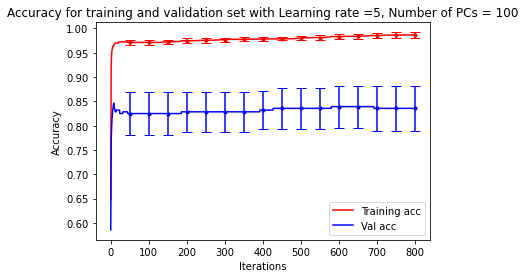

In [153]:
plt.plot(average_train_acc[0,:],color = 'red',label = 'Training acc')
plt.plot(average_val_acc[0,:],color = 'blue',label = 'Val acc')

plt.title("Accuracy for training and validation set with Learning rate ="+str(learning_rate)+", Number of PCs = "+str(num_PC))
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.legend()

errorbar_x_acc = np.zeros((1,int(max_iter/50) ))
errorbar_train_acc = np.zeros((1,int(max_iter/50)))
errorbar_val_acc = np.zeros((1,int(max_iter/50) ))
errorbar_y_train_acc = np.zeros((1,int(max_iter/50)))
errorbar_y_val_acc = np.zeros((1,int(max_iter/50)))

for p in range(int(max_iter/50)):
    
    errorbar_x_acc[0][p] = 50*(p+1)
    errorbar_train_acc[0][p] = std_train_acc[0][50*(p+1)-1]
    errorbar_val_acc[0][p] = std_val_acc[0][50*(p+1)-1]
    errorbar_y_train_acc[0][p] = average_train_acc[0][50*(p+1)-1]
    errorbar_y_val_acc[0][p] = average_val_acc[0][50*(p+1)-1]
    



plt.errorbar(errorbar_x_acc[0,:], errorbar_y_train_acc[0,:], errorbar_train_acc[0,:],fmt = '.r', capsize=5)
plt.errorbar(errorbar_x_acc[0,:], errorbar_y_val_acc[0,:], errorbar_val_acc[0,:],fmt = '.b', capsize=5)

plt.savefig('./plots/5c_acc_lr_'+str(learning_rate)+'_pc_'+str(num_PC)+'.png')
plt.show()

In [154]:
#save loss and its errorbar information for this parameter
average_train[0,:].tofile('trainloss_lr_'+str(learning_rate)+'_numPC'+str(num_PC)+'.dat')


In [155]:
error_bar_info = np.vstack((errorbar_x[0,:], errorbar_y_train[0,:], errorbar_train[0,:]))
print(error_bar_info.shape)

(3, 16)


In [156]:
error_bar_info.tofile('errorbar_lr_'+str(learning_rate)+'_numPC'+str(num_PC)+'.dat')